<img src='https://data.cityofchicago.org/api/assets/73F1665C-0FE6-4183-8AD1-E91DB8EFAFA4?7CB02402-8E06-48B0-8C9A-3890182D58C7.png'>

## Package setup.

In [21]:
# # In case you have the wrong version of Pandas installed, remove it and install the ver that's compat with PandasAI in your venv. 
# !pip uninstall pandas -y # Remove an pre 1.5.3
# !pip uninstall numpy -y

# Install some needed packages
!pip install -U pandasai --quiet
!pip install -U plotly --quiet
!pip install pyyaml --quiet
!pip install seaborn
!pip install wordcloud

# Show the package vers
!pip show pandas
!pip show pandasai

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached wordcloud-1.9.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.3-cp312-cp312-macosx_11_0_arm64.whl (169 kB)
Name: pandas
Version: 1.5.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /Users/eric/Library/CloudStorage/OneDrive-Personal/dev/pandasAi/.venv/lib/python3.12/site-packages
Requires: numpy, numpy, python-dateutil, pytz
Required-by: pandasai, seaborn
Name: pandasai
Version: 2.2.1
Summary: Chat with your database (SQL, CSV, pandas, polars, mongodb, noSQL, etc). PandasAI makes data analysis conversational using LLMs (GPT 3.5 / 4, Anthropic, VertexAI) and RAG.
Home-page: 
Author: Gabriele Venturi
Author-email: 
License: MIT
Location: /Users/eric/Li

## Read the local crime csv

In [6]:
import pandas as pd
crime = pd.read_csv('./data/chicago_iucr.csv')

import warnings
warnings.filterwarnings('ignore')


## Create a head Df to help the AI with col name descs. 

In [7]:
df_head = crime.head(3)

In [8]:
field_descriptions = {
    "id": "Unique identifier for the record.",
    "date": "The Date when the incident occurred. Stored as text.",
    "block": "Partially redacted address where the incident occurred, within the same block as the actual address.",
    "location_description": "Description of the location where the incident occurred.",
    "arrest": "Indicates whether an arrest was made.",
    "domestic": "Indicates whether the incident was domestic-related as per the Illinois Domestic Violence Act.",
    "beat": "Police beat where the incident occurred, part of the smallest police geographic area.",
    "district": "Police district where the incident occurred.",
    "ward": "City Council district (ward) where the incident occurred.",
    "community_area": "Indicates the community area where the incident occurred, with Chicago having 77 community areas.",
    "fbi_code": "Crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS).",
    "latitude": "Latitude of the incident location, shifted for partial redaction but on the same block.",
    "longitude": "Longitude of the incident location, shifted for partial redaction but on the same block.",
    "crime": "The crime committed, aka the incident."
}


## Import all our Pandas AI stuff & set up our GPT Model (Azure, OpenAI or Local) Behavior

In [9]:
import os
from pandasai import SmartDataframe
from pandasai.llm import AzureOpenAI
from pandasai.llm.local_llm import LocalLLM
from pandasai.llm import OpenAI
from pandasai import Agent
from pandasai.llm.openai import OpenAI
from pandasai.connectors import PandasConnector
from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# Get my Openai Var Key
open_ai_key = os.getenv('OPENAI_API_KEY')

# Choose the model
select_model = 'OpenAI' #OpenAI $$, #AzureOpenAI #Presdio #Local MyModel mY Macbook

if select_model == 'Azure':
    # Define the LLM model for Azure (if True)
    azure_api_key = os.getenv('AZURE_OPENAI_API_KEY')
    azure_api_ver = os.getenv('AZURE_API_VERSION')
    azure_api_endpt = os.getenv('AZURE_OPENAI_ENDPOINT')
    azure_oai_deployment = os.getenv('AZURE_OPENAI_DEPLOYMENT')
    llm = AzureOpenAI(
        api_token=azure_api_key,
        azure_endpoint=azure_api_endpt,
        api_version=azure_api_ver,
        deployment_name=azure_oai_deployment,
        temperature=0,
        seed=26,
    )
elif select_model == 'OpenAI':
    openai_api_key = os.getenv('OPENAI_API_KEY')
    llm = OpenAI(api_token=openai_api_key, 
                 temperature=0,
                 seed=35,
                )
    
elif select_model == 'Local':
    llm = LocalLLM(api_base="http://host.docker.internal:1234/v1",
                  temperature=0, 
                  seed=55,
                  )


# A description of the overall table
description = '''You are a data analysis agent. Your main goal is to help non-technical users to analyze data.\
                This dataset reflects reported incidents of crime (with the exception of murders where \
                data exists for each victim) that occurred in the City of Chicago from 2001 to present, \
                minus the most recent seven days. Data is extracted from the Chicago Police Department's \
                CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, \
                addresses are shown at the block level only and specific locations are not identified. '''

# Define my connector
agent = Agent(crime, config={'llm': llm,
                            'description': description,
                            'enable_cache': False,
                            'verbose': False,
                            'field_description': field_descriptions,
                            'save_charts': False,
                            'save_charts_path': './saved_plots',
                            'open_charts': False,
                            }
             )

## Simple Chat

In [17]:
crime

,date,block,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,latitude,longitude,location,crime
0,2024-06-06,033XX W NORTH AVE,COMMERCIAL / BUSINESS OFFICE,False,False,1422,14,26,23,06,41.910068,-87.710543,"{'latitude': '41.91006774', 'longitude': '-87....",THEFT - $500 AND UNDER
1,2024-06-06,046XX W DIVERSEY AVE,DEPARTMENT STORE,False,False,2521,25,31,20,11,41.931583,-87.742747,"{'latitude': '41.931582515', 'longitude': '-87...",DECEPTIVE PRACTICE - THEFT OF LOST / MISLAID P...
2,2024-06-06,001XX E 127TH ST,SIDEWALK,False,False,532,5,9,53,06,41.663459,-87.619634,"{'latitude': '41.663458528', 'longitude': '-87...",THEFT - OVER $500
3,2024-06-06,077XX S CONSTANCE AVE,STREET,False,True,414,4,8,43,06,41.754502,-87.579716,"{'latitude': '41.754501765', 'longitude': '-87...",THEFT - $500 AND UNDER
4,2024-06-06,018XX W 103RD ST,VEHICLE NON-COMMERCIAL,False,False,2212,22,19,72,14,41.706602,-87.668099,"{'latitude': '41.706602086', 'longitude': '-87...",CRIMINAL DAMAGE - TO VEHICLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2023-08-23,038XX W 32ND ST,STREET,False,False,1031,10,22,30,06,41.835114,-87.721214,"{'latitude': '41.835113738', 'longitude': '-87...",THEFT - OVER $500
199996,2023-08-23,004XX E 82ND ST,STREET,False,False,631,6,6,44,06,41.745663,-87.613224,"{'latitude': '41.745663212', 'longitude': '-87...",THEFT - OVER $500
199997,2023-08-23,035XX N BROADWAY,GROCERY FOOD STORE,False,False,1925,19,46,6,06,41.946212,-87.646580,"{'latitude': '41.946212132', 'longitude': '-87...",THEFT - OVER $500
199998,2023-08-23,080XX S DREXEL AVE,APARTMENT,False,True,631,6,8,44,08B,41.748522,-87.602678,"{'latitude': '41.748522062', 'longitude': '-87...",BATTERY - DOMESTIC BATTERY SIMPLE


'/Users/eric/Library/CloudStorage/OneDrive-Personal/dev/pandasAi/exports/charts/temp_chart.png'

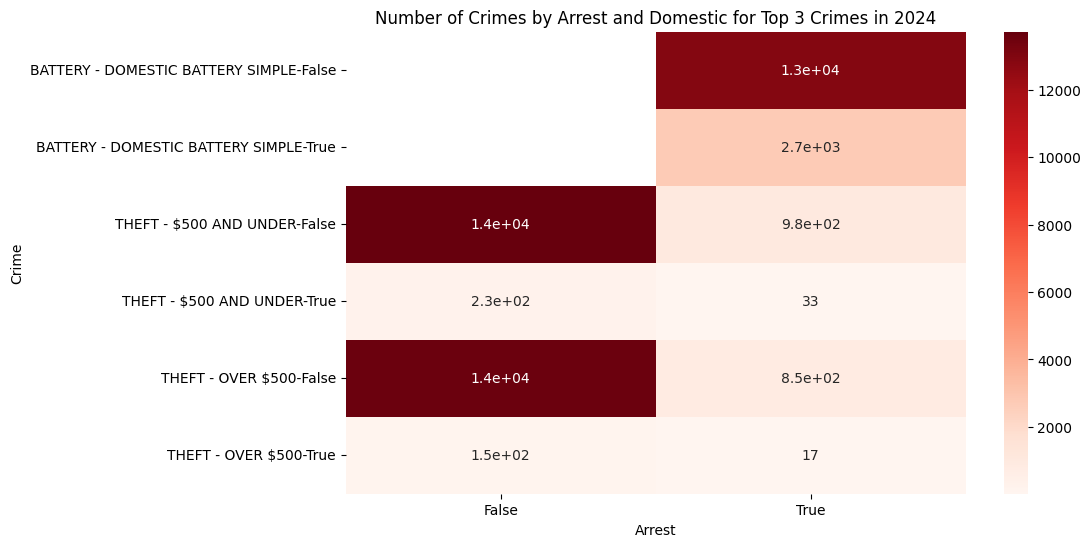

In [23]:
query = ''' use ploty not matplotlib! for the top 3 crimes in 2024, create a heatmap plot using seaborn for the number of crimes by arrest, domestic.  '''
agent.chat(query=query)

In [19]:
print(agent.last_code_generated)

# TODO: import the required dependencies
import pandas as pd

# Convert the data into a DataFrame
data = {'date': ['2024-04-26', '2023-11-07', '2023-09-03'],
        'block': ['031XX W 77TH ST', '031XX W DEVON AVE', '029XX W 42ND ST'],
        'location_description': ['BOAT / WATERCRAFT', '', 'VEHICLE - COMMERCIAL'],
        'arrest': [True, False, True],
        'domestic': [False, True, False],
        'beat': [913, 2432, 331],
        'district': [19, 24, 6],
        'ward': [9, 31, 29],
        'community_area': [38, 40, 57],
        'fbi_code': ['15', '08A', '04B'],
        'latitude': [41.895422074, 41.713204759, None],
        'longitude': [-87.642896985, None, -87.628608316],
        'location': [None, "{'latitude': '41.746792284', 'longitude': '-87.603837588', 'human_address': '{""address"": """", ""city"": """", ""state"": """", ""zip"": """"}'", "{'latitude': '41.900355967', 'longitude': '-87.761742894', 'human_address': '{""address"": """", ""city"": """", ""state"": """", 

In [12]:
agent.explain()

'I looked at the data from the previous year and grouped it by date to count the number of crimes that occurred each day. Then, I created a plot to show how the number of crimes changed over time. I added labels to the plot to make it easy to understand, and saved the plot as an image for you to view later.'